# Lab Assignment 3

**Submission deadline:**
* **Regular problems: Sunday 23:59 January 9th 2022**


**Points: 2+9+3+2+2 = 18 points**


In [2]:
# Please note that this code needs only to be run in a fresh runtime.
# However, it can be rerun afterwards too.
!pip install -q gdown httpimport

In [3]:
# Standard IPython notebook imports
%matplotlib inline

import os
from io import StringIO

import graphviz
import httpimport
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy.stats as sstats
import seaborn as sns
import sklearn.ensemble
import sklearn.tree
from tqdm import tqdm_notebook

# In this way we can import functions straight from github
with httpimport.github_repo(
    "janchorowski", "nn_assignments", module="common", branch="nn18"
):
    from common.plotting import plot_mat

sns.set_style("whitegrid")



In [4]:
# @title Data Loading
# We will load a few commonly used datasets:
# - mushroom
# - iris
# - adult
# - congressional voting
# - german credit


# 1. Mushroom dataset
# https://archive.ics.uci.edu/ml/datasets/mushroom
# only categorical attributes with missing values
columns = [
    "target",
    "cap-shape",
    "cap-surface",
    "cap-color",
    "bruises?",
    "odor",
    "gill-attachment",
    "gill-spacing",
    "gill-size",
    "gill-color",
    "stalk-shape",
    "stalk-root",
    "stalk-surface-above-ring",
    "stalk-surface-below-ring",
    "stalk-color-above-ring",
    "stalk-color-below-ring",
    "veil-type",
    "veil-color",
    "ring-number",
    "ring-type",
    "spore-print-color",
    "population",
    "habitat",
]

# Use read_csv to load the data.
url = "http://archive.ics.uci.edu/ml/machine-learning-databases/mushroom/agaricus-lepiota.data"
mushroom_df = pd.read_csv(url, header=None, names=columns)
mushroom_idx_df = mushroom_df.reset_index()

# 2. Iris
iris_url = "https://archive.ics.uci.edu/ml/machine-learning-databases/iris/iris.data"
iris_df = pd.read_csv(
    iris_url,
    header=None,
    names=["sepal_length", "sepal_width", "petal_length", "petal_width", "target"],
)

# 3. Congressoinal Voting
# Binary attributes, binary class, missing data
vote_df = (
    pd.read_csv(
        "https://pkgstore.datahub.io/machine-learning/vote/vote_csv/data/65f1736301dee4a2ad032abfe2a61acb/vote_csv.csv"
    )
    .rename({"Class": "target"}, axis=1)
    .fillna("na")
)

# 4. Adult
# census records, continuous and categorical attributes (some ordered), missing values
adult_names = [
    "Age",
    "Workclass",
    "fnlwgt",
    "Education",
    "Education-Num",
    "Martial Status",
    "Occupation",
    "Relationship",
    "Race",
    "Sex",
    "Capital Gain",
    "Capital Loss",
    "Hours per week",
    "Country",
    "target",
]
adult_df = pd.read_csv(
    "https://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.data",
    names=adult_names,
    header=None,
    na_values="?",
)
adult_test_df = pd.read_csv(
    "https://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.test",
    names=adult_names,
    header=None,
    na_values="?",
    skiprows=1,
)

# 5. German Credit

german_df = pd.read_csv(
    "https://archive.ics.uci.edu/ml/machine-learning-databases/statlog/german/german.data",
    names=[f"A{d}" for d in range(1, 21)] + ["target"],
    header=None,
    sep=" ",
)

# Problem 1 [2p] 

Download a categorical dataset, such as the [mushroom](https://archive.ics.uci.edu/ml/datasets/mushroom) from UCI and try to find the most predictive variables: 

### Implement mutual information [1p]

Implement the function `entropy` to compute the entropy of a column of the dataset.

The [entropy](https://en.wikipedia.org/wiki/Entropy_(information_theory)) of a discrete variable is defined to be:

$$H(X) = -\sum_x p_X(x) \log_2 p_X(x).$$

A good in tutorial is given by Chris Olah: https://colah.github.io/posts/2015-09-Visual-Information/.


When $X$ is a discrete random variable, we can estimate the probabilities with counts:

$$p_X(x) = \frac{\text{number of instances where }X=x}{\text{total number of instances}}.$$


Hint: the following `pandas` functions may be useful:
- `count`
- `value_count`

Then use the dataframe's `apply` function to compute the entropy of all columns.

In [5]:
def entropy(series):
    n_instances = series.count()
    value_counts = series.value_counts()

    def sum_part(value_count):
        p = value_count/n_instances
        return p * np.log2(p)

    return -sum_part(value_counts).sum()

# mushroom_df.apply(lambda x: round(entropy(x), 3))
mushroom_df.apply(entropy)


target                      0.999068
cap-shape                   1.652889
cap-surface                 1.575486
cap-color                   2.510143
bruises?                    0.979327
odor                        2.319414
gill-attachment             0.173129
gill-spacing                0.637878
gill-size                   0.892256
gill-color                  3.030433
stalk-shape                 0.986927
stalk-root                  1.822922
stalk-surface-above-ring    1.221348
stalk-surface-below-ring    1.399135
stalk-color-above-ring      1.936809
stalk-color-below-ring      1.978163
veil-type                  -0.000000
veil-color                  0.196238
ring-number                 0.420680
ring-type                   1.535121
spore-print-color           2.203227
population                  2.003398
habitat                     2.274747
dtype: float64

Implement the conditional entropy computation

$$H(Y|X) = \sum_x p_X(x) H(Y|x) = \sum_x p_X(x) \sum_y p_Y(y|x) \log_2 p_Y(y|x)$$

Hint 1: the above formula can be computed as follows:
1. split the data by the values of $X$
2. for each value $x$ that $X$ takes, compute the entropy of $Y$
3. average the entropies, weighing them by how frequently the value $x$ occured.

Hint 2: helpful pandas constructs are:
- `groupby` and `agg`
- you can aggregate a grouping using your own custom functions


In [7]:
def cond_entropy(Y, X):
    """Compute the conditional H(Y|X) in dataframe df
    Args:
        Y: series whose entropy we wish to compute
        X: series on which we condition
    """
    #TODO implement conditional entropy here
    n_instances = X.count()
    X_counts = X.value_counts().to_dict()
    XY = pd.concat([X, Y], axis=1)
    XY.columns = ['X', 'Y']
    XY_counts = XY.value_counts().to_dict()
    
    res = 0

    for x in X.unique():
        px = X_counts.get(x, 0)/n_instances
        y_sum = 0
        for y in Y.unique():
            py = XY_counts.get((x,y), 0)/X_counts.get(x,0)
            if py != 0:
                y_sum += py * np.log2(py)

        res -= px * y_sum

    return res

# # pd.concat([mushroom_df['target'], mushroom_df['cap-shape']], axis=1)


for cname in mushroom_df.columns:
    print(f"{cname.ljust(25)}:\t {cond_entropy(mushroom_df['target'], mushroom_df[cname]).round(decimals=3)}")

target                   :	 0.0
cap-shape                :	 0.95
cap-surface              :	 0.97
cap-color                :	 0.963
bruises?                 :	 0.807
odor                     :	 0.093
gill-attachment          :	 0.985
gill-spacing             :	 0.898
gill-size                :	 0.769
gill-color               :	 0.582
stalk-shape              :	 0.992
stalk-root               :	 0.864
stalk-surface-above-ring :	 0.714
stalk-surface-below-ring :	 0.727
stalk-color-above-ring   :	 0.745
stalk-color-below-ring   :	 0.758
veil-type                :	 0.999
veil-color               :	 0.975
ring-number              :	 0.961
ring-type                :	 0.681
spore-print-color        :	 0.518
population               :	 0.797
habitat                  :	 0.842


In [8]:
def joint_entropy(X, Y):
    n_instances = X.count()
    XY = pd.concat([X, Y], axis=1)
    XY.columns = ['X', 'Y']
    XY_counts = XY.value_counts().to_dict()

    res = 0
    for x in X.unique():
        for y in Y.unique():
            pxy = XY_counts.get((x,y), 0)/n_instances
            if pxy != 0:
                res -= pxy * np.log2(pxy)

    return res

def mutual_information(X, Y):
    #TODO implement mutual information using the formula H(X,Y) - E(X|Y) - E(Y|X)
    return joint_entropy(X,Y) - cond_entropy(X, Y) - cond_entropy(Y,X)
    
    

for cname in mushroom_df.columns:
    print(f"{cname.ljust(25)}:\t {mutual_information(mushroom_df['target'], mushroom_df[cname]).round(decimals=3)}")

target                   :	 0.999
cap-shape                :	 0.049
cap-surface              :	 0.029
cap-color                :	 0.036
bruises?                 :	 0.192
odor                     :	 0.906
gill-attachment          :	 0.014
gill-spacing             :	 0.101
gill-size                :	 0.23
gill-color               :	 0.417
stalk-shape              :	 0.008
stalk-root               :	 0.135
stalk-surface-above-ring :	 0.285
stalk-surface-below-ring :	 0.272
stalk-color-above-ring   :	 0.254
stalk-color-below-ring   :	 0.241
veil-type                :	 0.0
veil-color               :	 0.024
ring-number              :	 0.038
ring-type                :	 0.318
spore-print-color        :	 0.481
population               :	 0.202
habitat                  :	 0.157


We can see from the above listing that the features that share the most information with the target are "odor" (0.906), "spore-print-color" (0.481), and "gill-color" (0.417). Let us remember that once we will have a final decision tree.

## Correlation vs mutual information

Here's an example for why we care about mutual information in the first place.
There are very natural cases when correlation of two random variables is very low (in the example it's actually a perfect 0), even though they may be incredibly dependent. It turns out that zero correlation only tells us whether two random variables do not have any linear relationship between them.

,x,|x|
-1.0,-1.0,1.0
0.0,0.0,0.0
1.0,1.0,1.0


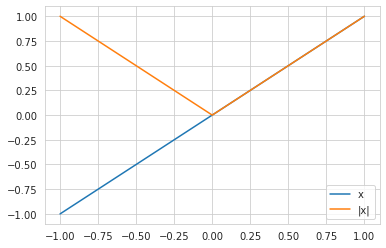

In [9]:
df = pd.DataFrame(index=np.linspace(-1,1,3))
df['x'] = df.index
df['|x|'] = np.abs(df['x'])
df.plot()
df

Correlation (covariance) of random variables X and |X| is 0.

In [51]:
df['x'].dot(df['|x|'])

0.0

However, they are very dependent, since knowing $x$ immediately tells us what the value of $|x|$ is. 
And this actually can be seen by looking at the conditional entropy of $H(|X|\ | X)$ the variables.

In [10]:
cond_entropy(df["|x|"], df["x"]).round(decimals=9)

0.0

The above result clearly implements our intuition --- once we know $x$, there's no uncertainty left about $|x|$.

What about the reverse conditioning?

In [11]:
entropy(df['x']), np.log2(3)

(1.584962500721156, 1.584962500721156)

In [12]:
entropy(df['|x|']), (1/3)*np.log2(3) + (2/3)*np.log2(3/2)

(0.9182958340544896, 0.9182958340544893)

In [13]:
cond_entropy(df["x"], df["|x|"]).round(decimals=3)

0.667

This result has a natural intepretation: 1 cases out of 3 $|x|$ is zero in which case we know what $x$ is, so in this case the entropy is $0$, cause there's no uncertainty left. 2 cases out of 3 we have $|x| = 1$, in which case the uncertainty which remains is the probability distribution of the sign. The probability distribution of the sign is just $P(\text{sign is }+) = 1/2 = P(\text{sign is }-)$ and its entropy is $-\left(\frac{1}{2}\log(1/2) + \frac{1}{2}\log(1/2)\right)=1$. Hence the total conditional entropy is $\frac{2}{3}$.

At the end let us look at the actual mutual information based on what we already saw.

In [14]:
mutual_information(df['x'], df['|x|'])

0.9182958340544894

Makes sense, right?

### Implement infogain ratio [1p]
Add an ID column that assigns a unique ID to each observation (row). Compute the mutual information between target and ID. How to interpret the results? Do you think the ID is important in predicting the target? Devise a measure similar to Information Gain Ratio from C4.5 and show its variable ranking.



In [15]:
def information_gain_ratio(T, S):
    return mutual_information(T, S)/entropy(S)

cond_entropy_target_index = cond_entropy(mushroom_idx_df['target'], mushroom_idx_df['index'])
mut_inf_target_index = mutual_information(mushroom_idx_df['target'], mushroom_idx_df['index'])
print(f"H(target|ID): {cond_entropy_target_index}")
print(f"I(target, ID): {mut_inf_target_index.round(decimals=3)}")

for cname in mushroom_idx_df.columns:
    T = mushroom_idx_df['target']
    S = mushroom_idx_df[cname]
    print(f"{cname.ljust(25)}:\t IG {mutual_information(T, S).round(decimals=3)} \t IGR {information_gain_ratio(T, S).round(decimals=3)}")

H(target|ID): 0.0
I(target, ID): 0.999
index                    :	 IG 0.999 	 IGR 0.077
target                   :	 IG 0.999 	 IGR 1.0
cap-shape                :	 IG 0.049 	 IGR 0.03
cap-surface              :	 IG 0.029 	 IGR 0.018
cap-color                :	 IG 0.036 	 IGR 0.014
bruises?                 :	 IG 0.192 	 IGR 0.196
odor                     :	 IG 0.906 	 IGR 0.391
gill-attachment          :	 IG 0.014 	 IGR 0.082
gill-spacing             :	 IG 0.101 	 IGR 0.158
gill-size                :	 IG 0.23 	 IGR 0.258
gill-color               :	 IG 0.417 	 IGR 0.138
stalk-shape              :	 IG 0.008 	 IGR 0.008
stalk-root               :	 IG 0.135 	 IGR 0.074
stalk-surface-above-ring :	 IG 0.285 	 IGR 0.233
stalk-surface-below-ring :	 IG 0.272 	 IGR 0.194
stalk-color-above-ring   :	 IG 0.254 	 IGR 0.131
stalk-color-below-ring   :	 IG 0.241 	 IGR 0.122
veil-type                :	 IG 0.0 	 IGR nan
veil-color               :	 IG 0.024 	 IGR 0.121
ring-number              :	 IG 0.038 	

/tmp/ipykernel_77655/3631655031.py:2: RuntimeWarning: invalid value encountered in double_scalars
  return mutual_information(T, S)/entropy(S)


# Problem 2: Decision Tree Implementation [9p]

Currently, there are no good implementations of Decision Trees in Python.

Sadly, the machine learning toolkit [sklearn](https://scikit-learn.org/stable/index.html) doesn't handle categorical attributes. Let's use this as an excuse to implement Decision Tress ourselves.



## Decision Tree Task 1: Purity Measures [1p]

Please fill the purity measures below.

Verify the correctness by plotting the purity values for a two-class set with given class probabilities.

In [16]:
def entropy(counts):
    n = sum(counts)
    probs = [c/n for c in counts]
    res = 0
    for p in counts:
        if p != 0:
            res -= p * np.log2(p)

    def sum_part(p):
        if p == 0:
            return 0
        else:
            return p * np.log2(p)

    return -sum(list(map(sum_part, probs)))


def gini(counts):
    n = sum(counts)
    probs = [c/n for c in counts]
    return 1 - sum([p**2 for p in probs])


def mean_err_rate(counts):
    s = sum(counts)
    p = counts / s
    return 1 - p.max()


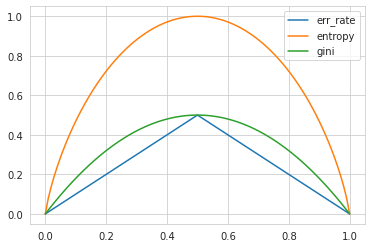

In [59]:
# Make a plot of the purity functions
fractions = np.linspace(0, 1, 101)
# We have to do a for loop, because we will be supplying pandas series later on
err_rates = [mean_err_rate(np.array([f, 1.0-f])) for f in fractions]
entropies = [entropy(np.array([f, 1.0-f])) for f in fractions]
ginies = [gini(np.array([f, 1.0-f])) for f in fractions]
plt.plot(fractions, err_rates, label="err_rate")
plt.plot(fractions, entropies, label="entropy")
plt.plot(fractions, ginies, label="gini")
plt.legend()
plt.show()

## Decision Tree Task 2: Categorical Splits [1p]

### The anatomy of a Decision Tree


All internal (non-leaf) nodes of a split training examples according to a test implemented by the node. We capture this behavior using a generic `AbstractSplit` class which implements a split of data contained in the dataframe `df` using the attribute `attr`.

The class features a lightweight constructor, `__init__` which only saves the information required to later split a training dataframe and recursively build the subtrees using the `build_subtrees` method.

Fill in the blanks in the code below, as indicated by the TODO comments.

In [17]:
class AbstractSplit:
    """Split the examples in a tree node according to a criterion.
    """

    def __init__(self, attr):
        self.attr = attr

    def __call__(self, x):
        """Return the subtree corresponding to x."""
        raise NotImplementedError

    def build_subtrees(self, df, subtree_kwargs):
        """Recuisively build the subtrees."""
        raise NotImplementedError

    def iter_subtrees(self):
        """Return an iterator over subtrees."""
        raise NotImplementedError

    def add_to_graphviz(self, dot):
        """Add the split to the graphviz vizalization."""
        raise NotImplementedError

    def __str__(self):
        return f"{self.__class__.__name__}: {self.attr}"

We will first implement a Multivariate Categorical split which has a subtree for each value that an attribute may take.

In [81]:
class CategoricalMultivalueSplit(AbstractSplit):
    def build_subtrees(self, df, subtree_kwargs):
        self.subtrees = {}
        for group_name, group_df in df.groupby(self.attr):
            child = Tree(group_df, **subtree_kwargs)
            self.subtrees[group_name] = child

    def __call__(self, x):
        # Return the subtree for the given example
        # print(type(self.attr))
        if (x[self.attr] not in self.subtrees.keys()):
            return None
        return self.subtrees[x[self.attr]]

    def iter_subtrees(self):
        return self.subtrees.values()

    def add_to_graphviz(self, dot, parent, print_info):
        for split_name, child in self.subtrees.items():
            child.add_to_graphviz(dot, print_info)
            dot.edge(f"{id(parent)}", f"{id(child)}", label=f"{split_name}")


In [19]:
def get_categorical_split_and_purity(
    df, parent_purity, purity_fun, attr, normalize_by_split_entropy=False
):
    """Return a multivariate split and its purity.
    Args:
        df: a dataframe
        parent_purity: purity of the parent node
        purity_fun: function to compute the purity
        attr: attribute over whihc to split the dataframe
        normalize_by_split_entropy: if True, divide the purity gain by the split
            entropy (to compute https://en.wikipedia.org/wiki/Information_gain_ratio)
    
    Returns:
        pair of (split, purity_gain)
    """
    split = CategoricalMultivalueSplit(attr)

    
    # Compute the purity after the split

    mean_child_purity = 0

    for _, group_df in df.groupby(attr):
        val_counts = group_df['target'].value_counts().values
        size = val_counts.sum()
        arr = [val_counts[0]/size, 1-val_counts[0]/size]
        mean_child_purity += purity_fun(arr) * size
        
    mean_child_purity /= df.size

    
    # Note: when purity is measured by entropy, this corresponds to Mutual Information
    purity_gain = parent_purity - mean_child_purity
    if normalize_by_split_entropy:
        purity_gain /= entropy(df[attr].value_counts())
    return split, purity_gain

In [20]:
def get_split(df, criterion="mean_err_rate", nattrs=None):
    """Find best split on the given dataframe.
    
    Attributes:
        - df: the dataframe of smaples in the node to be split
        - criterion: spluis selection criterion
        - nattrs: flag to randomly limit the number of considered attributes. Used 
          in random tree impementations.

    Returns:
        - If no split exists, return None.
        - If a split exists, return an instance of a subclass of AbstractSplit
    """
    # Implement termination criteria:
    # TermCrit1: Node is pure
    target_value_counts = df["target"].value_counts()
    if len(target_value_counts) == 1:
        return None
    # TermCrit2: No split is possible
    #    First get a list of attributes that can be split
    #    (i.e. attribute is not target and atribute can take more than one value)
    #
    #    The list of attributes on which we can split will also be handy for building random trees.
    possible_splits = [attr for attr in df.columns if attr != "target" and len(df[attr].value_counts()) > 1]
    assert "target" not in possible_splits
    #    Terminate early if none are possible
    if not possible_splits:
        return None

    # Get the base purity measure and the purity function
    if criterion in ["infogain", "infogain_ratio"]:
        purity_fun = entropy
    elif criterion in ["mean_err_rate"]:
        purity_fun = mean_err_rate
    elif criterion in ["gini"]:
        purity_fun = gini
    else:
        raise Exception("Unknown criterion: " + criterion)
    base_purity = purity_fun(target_value_counts)

    best_purity_gain = -1
    best_split = None

    # Random Forest support
    # restrict possible_splits to a few radomly selected attributes
    if nattrs is not None:
        # if len(possible_splits) > nattrs:
        possible_splits = np.random.choice(possible_splits, nattrs)
    

    for attr in possible_splits:
        if np.issubdtype(df[attr].dtype, np.number):
            # Handling of numerical attributes will be defined later, in a manner
            # similar to categorical ones
            split_sel_fun = get_numerical_split_and_purity
        else:
            split_sel_fun = get_categorical_split_and_purity

        split, purity_gain = split_sel_fun(
            df,
            base_purity,
            purity_fun,
            attr,
            normalize_by_split_entropy=criterion.endswith("ratio"),
        )

        if purity_gain > best_purity_gain:
            best_purity_gain = purity_gain
            best_split = split
    return best_split

We can now define a Tree class, which represents both a Decision Tree and its Nodes.

Each node saves its class distribution in the `counts` attribute and debug/visualization information in the `info` field. 

Leaf nodes have `split == None`, while internal nodes have a split which points to subtrees.


In [21]:
class Tree:
    def __init__(self, df, **kwargs):
        super().__init__()
        # Assert that threre are no missing values,
        # TODO: remove this for bonus problem #2.4
        assert not df.isnull().values.any()

        # Technicality:
        # We need to let subtrees know about all targets to properly color nodes
        # We pass this in subtree arguments.
        if "all_targets" not in kwargs:
            kwargs["all_targets"] = sorted(df["target"].unique())
        # Save keyword arguments to build subtrees
        kwargs_orig = dict(kwargs)

        # Get kwargs we know about, remaning ones will be used for splitting
        self.all_targets = kwargs.pop("all_targets")

        # Save debug info for visualization
        # Debugging tip: contents of self.info are printed in tree visualizations!
        self.counts = df["target"].value_counts()

        self.pruning_counts = df["target"].value_counts() * 0

        self.info = {
            "num_samples": len(df),
            "entropy": entropy(self.counts),
            "gini": gini(self.counts),
            # "classifications": {"ok": 0, "err": 0, "err_rate": 0}
        }

        self.split = get_split(df, **kwargs)
        if self.split:
            self.split.build_subtrees(df, kwargs_orig)



    def reset_pruning_counts(self):
        # self.info["classifications"] = {"ok": 0, "err": 0, "err_rate": 0}
        self.counts -= self.pruning_counts
        self.pruning_counts *= 0

        if (self.split):
            for subtree in self.split.iter_subtrees():
                subtree.reset_pruning_counts()

    def get_target_distribution(self, sample):
        if self.split is None:
            return self.counts
        else:
            # TODO: descend into subtrees and return the leaf target distribution

            # subtree can be None if no row from training df has the same attr value as sample
            subtree = self.split(sample)
            if subtree == None:
                return self.counts

            return subtree.get_target_distribution(sample)
        

    def classify(self, sample):
        # TODO: classify the sample by descending into the appropriate subtrees.
        # Hint: you can also use self.get_target_distribution
        leaf_counts = self.get_target_distribution(sample)
        return leaf_counts.idxmax()

    def log_distribution(self, sample):
        self.counts[sample['target']] += 1
        self.pruning_counts[sample['target']] += 1
        if self.split:
            subtree = self.split(sample)
            subtree.log_distribution(sample)

    def log_classification(self, sample):
        if self.counts.idxmax() == sample['target']:
            self.info["classifications"]['ok'] += 1
        else:
            self.info["classifications"]['err'] += 1

        self.info["classifications"]['err_rate'] = self.info["classifications"]['err'] / (self.info["classifications"]['err'] + self.info["classifications"]['ok'])

        if self.split:
            subtree = self.split(sample)
            if subtree:
                subtree.log_classification(sample)

    def prune_leaves(self):
        if (self.split):
            keys = self.split.subtrees.keys()
            to_prune = []
            for attr in keys:
                subtree = self.split.subtrees[attr]
                if subtree.split:
                    subtree.prune_leaves()
                else:
                    if subtree.err_rate() > self.err_rate():
                        # self.split.subtrees.pop(attr)
                        to_prune.append(attr)

            for k in to_prune:
                self.split.subtrees.pop(k)

    def prune_nodes(self):
        if (self.split):
            keys = self.split.subtrees.keys()
            to_prune = []
            for attr in keys:
                subtree = self.split.subtrees[attr]
                if subtree.err_rate() > self.err_rate():
                    # self.split.subtrees.pop(attr)
                    to_prune.append(attr)
                else:
                    subtree.prune_nodes()

            for k in to_prune:
                self.split.subtrees.pop(k)


    # def prune_small_err_rates(self, max_err_rate):
    #     if self.err_rate <= max_err_rate:
    #         self.split = None
    #     else:
    #         for subtree in self.split.subtrees:
    #             subtree.prune_small_err_rates(max_err_rate)

    def err_rate(self):
        return self.info["classifications"]['err_rate']

    def draw(self, print_info=True):
        dot = graphviz.Digraph()
        self.add_to_graphviz(dot, print_info)
        return dot

    def add_to_graphviz(self, dot, print_info):
        freqs = self.counts / self.counts.sum()
        freqs = dict(freqs)
        colors = []
        freqs_info = []
        for i, c in enumerate(self.all_targets):
            freq = freqs.get(c, 0.0)
            if freq > 0:
                colors.append(f"{i%9 + 1};{freq}")
                freqs_info.append(f"{c}:{freq:.2f}")
        colors = ":".join(colors)
        labels = [" ".join(freqs_info)]
        if print_info:
            for k, v in self.info.items():
                labels.append(f"{k} = {v}")
        if self.split:
            labels.append(f"split by: {self.split.attr}")
        dot.node(
            f"{id(self)}",
            label="\n".join(labels),
            shape="box",
            style="striped",
            fillcolor=colors,
            colorscheme="set19",
        )
        if self.split:
            self.split.add_to_graphviz(dot, self, print_info)

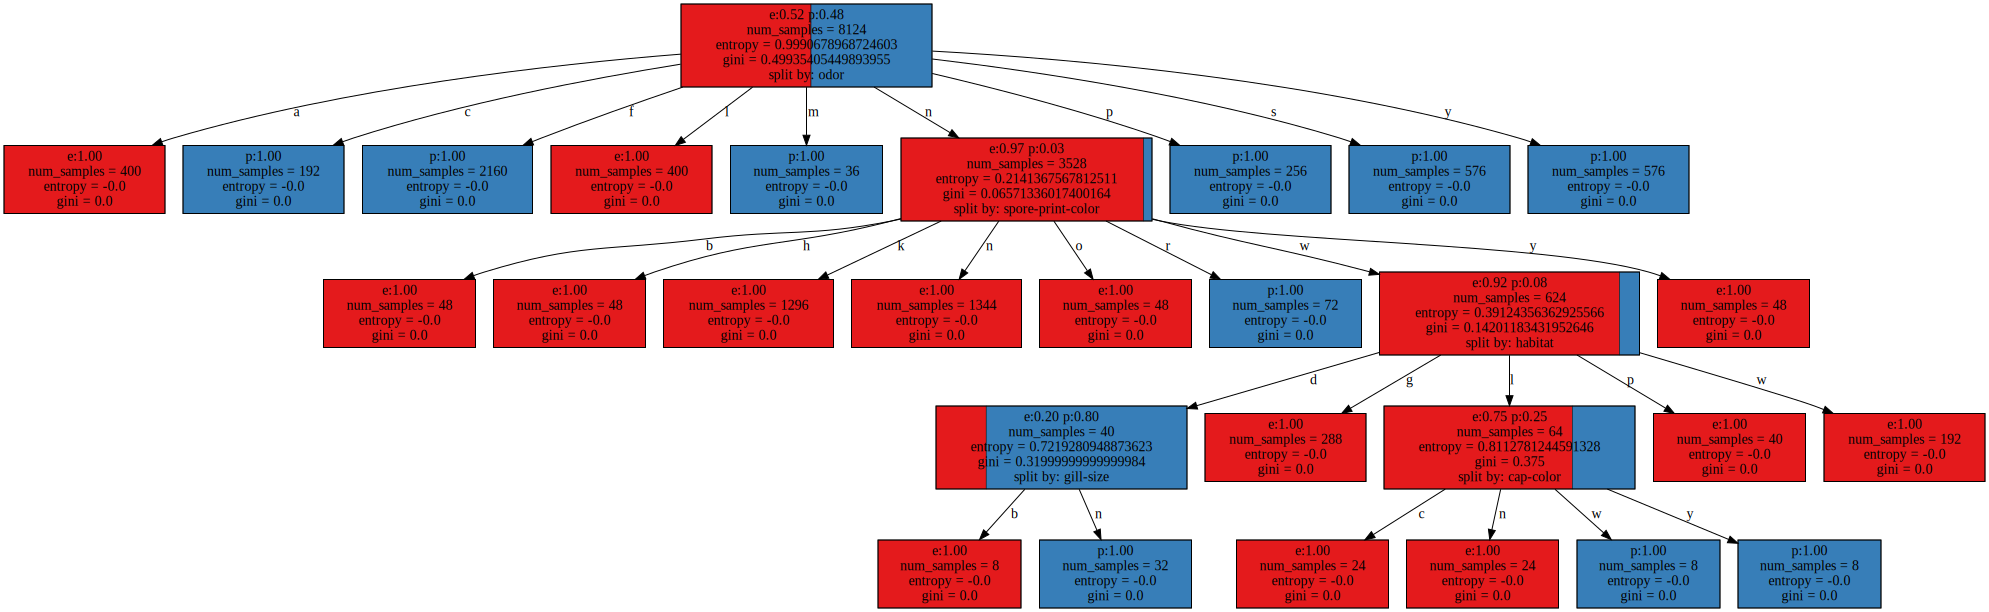

In [83]:
# Train a Decision Tree on the mushroom data.
# Plot the tree using the `.draw()` method.

# Note: for this code to work you must fix the todos in the previous sections

mushroom_tree = Tree(mushroom_df)
mushroom_tree.draw()

**Answer the questions below:**
1. How many samples are classified correctly by a tree with only one split?
    8124 - 3528 * 0.03 = 8018
2. Is the tree different when different purity functions are used?
    
***Answers***
1. 8124 - 3528 * 0.03 = 8018
2. When mean error is used, tree is different

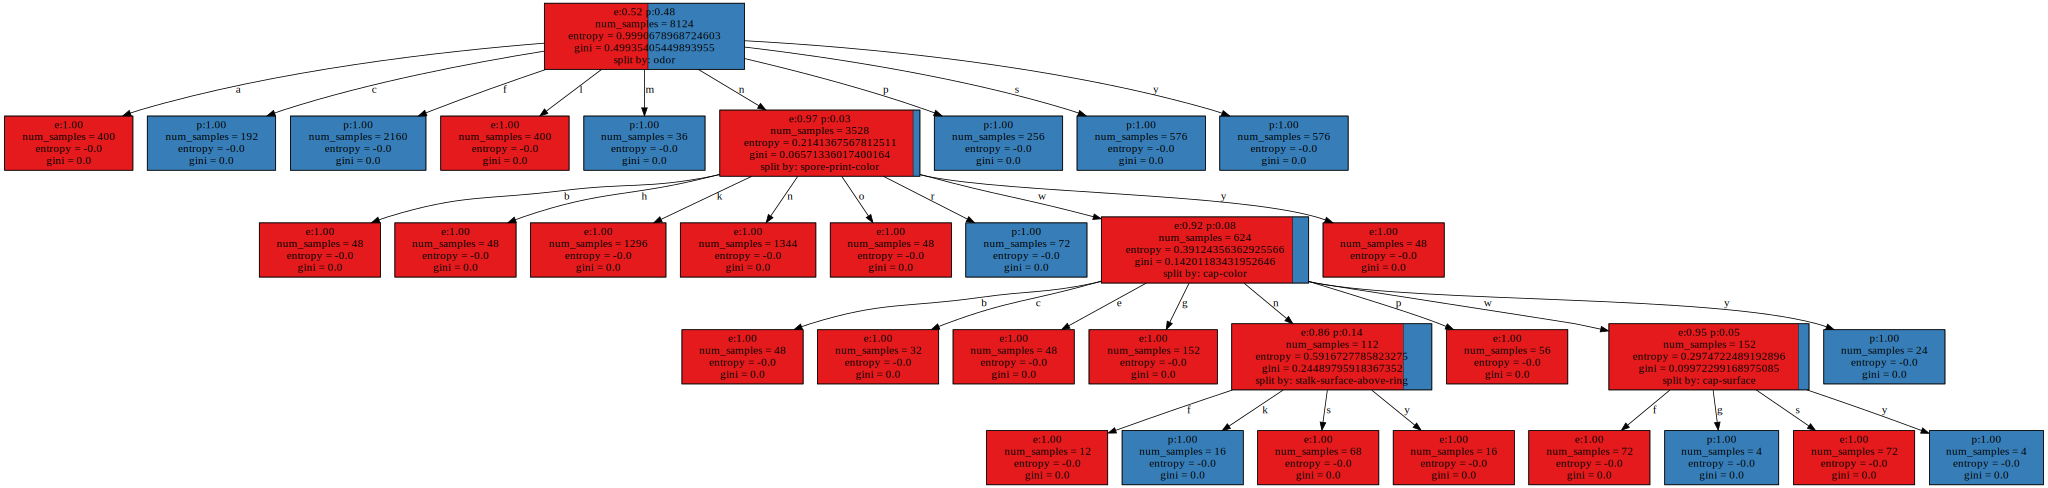

In [22]:
#Tree for mean_err is different

mushroom_tree = Tree(mushroom_df)
mushroom_tree.draw()

## Decision Tree Task 3: Numerical Splits [1p]
A numerical split requires to search for the best threshold. Implement the selection of splits for numerical attributes below.

In [80]:
class NumericalSplit(AbstractSplit):
    def __init__(self, attr, th):
        super(NumericalSplit, self).__init__(attr)
        self.th = th

    def build_subtrees(self, df, subtree_kwargs):
        self.subtrees = (
            Tree(df[df[self.attr] <= self.th], **subtree_kwargs),
            Tree(df[df[self.attr] > self.th], **subtree_kwargs),
        )

    def __call__(self, x):
        # return the subtree for the data sample `x`
        if (x[self.attr] <= self.th):
            return self.subtrees[0]
        else:
            return self.subtrees[1]

    def __str__(self):
        return f"NumericalSplit: {self.attr} <= {self.th}"

    def iter_subtrees(self):
        return self.subtrees

    def add_to_graphviz(self, dot, parent, print_info):
        self.subtrees[0].add_to_graphviz(dot, print_info)
        dot.edge(f"{id(parent)}", f"{id(self.subtrees[0])}", label=f"<= {self.th:.2f}")
        self.subtrees[1].add_to_graphviz(dot, print_info)
        dot.edge(f"{id(parent)}", f"{id(self.subtrees[1])}", label=f"> {self.th:.2f}")


def get_numerical_split_and_purity(
    df, parent_purity, purity_fun, attr, normalize_by_split_entropy=False
):
    """Find best split thereshold and compute the average purity after a split.
    Args:
        df: a dataframe
        parent_purity: purity of the parent node
        purity_fun: function to compute the purity
        attr: attribute over whihc to split the dataframe
        normalize_by_split_entropy: if True, divide the purity gain by the split
            entropy (to compute https://en.wikipedia.org/wiki/Information_gain_ratio)
    
    Returns:
        pair of (split, purity_gain)
    """
    attr_df = df[[attr, "target"]].sort_values(attr)
    targets = attr_df["target"]
    values = attr_df[attr]
    # Start with a split that puts all the samples into the right subtree
    right_counts = targets.value_counts()
    left_counts = right_counts * 0

    best_split = None  # Will be None, or NumericalSplit(attr, best_threshold)
    best_purity_gain = -1
    N = len(attr_df)
    for row_i in range(N - 1):
        # Update the counts of targets in the left and right subtree and compute
        # the purity of the slipt for all possible thresholds!
        # Return the best split found.

        # Remember that the attribute may have duplicate values and all samples
        # with the same attribute value must end in the same subtree!
        row_target = targets.iloc[row_i]
        attribute_value = values.iloc[row_i]
        next_attribute_value = values.iloc[row_i + 1]
        split_threshold = (attribute_value + next_attribute_value) / 2.0

        # Consider the split at threshold, i.e. NumericalSplit(attr, split_threshold)
        # the loop should return the best possible split.

        # TODO: update left_counts and right_counts
        # print(row_i, targets[row_i])
        left_counts[row_target] += 1
        right_counts[row_target] -= 1
        

        # The split is possible if attribute_value != next_attribute_value
        if attribute_value == next_attribute_value:
            continue

        # TODO: now consider the split at split_threshold and save it if it the best one

        children_purity_avg = (left_counts.sum() * purity_fun(left_counts) + right_counts.sum() * purity_fun(right_counts)) / df.size
        purity_gain = parent_purity - children_purity_avg

        if purity_gain > best_purity_gain:
            best_purity_gain = purity_gain
            best_split = NumericalSplit(attr, split_threshold)
        
    return best_split, best_purity_gain

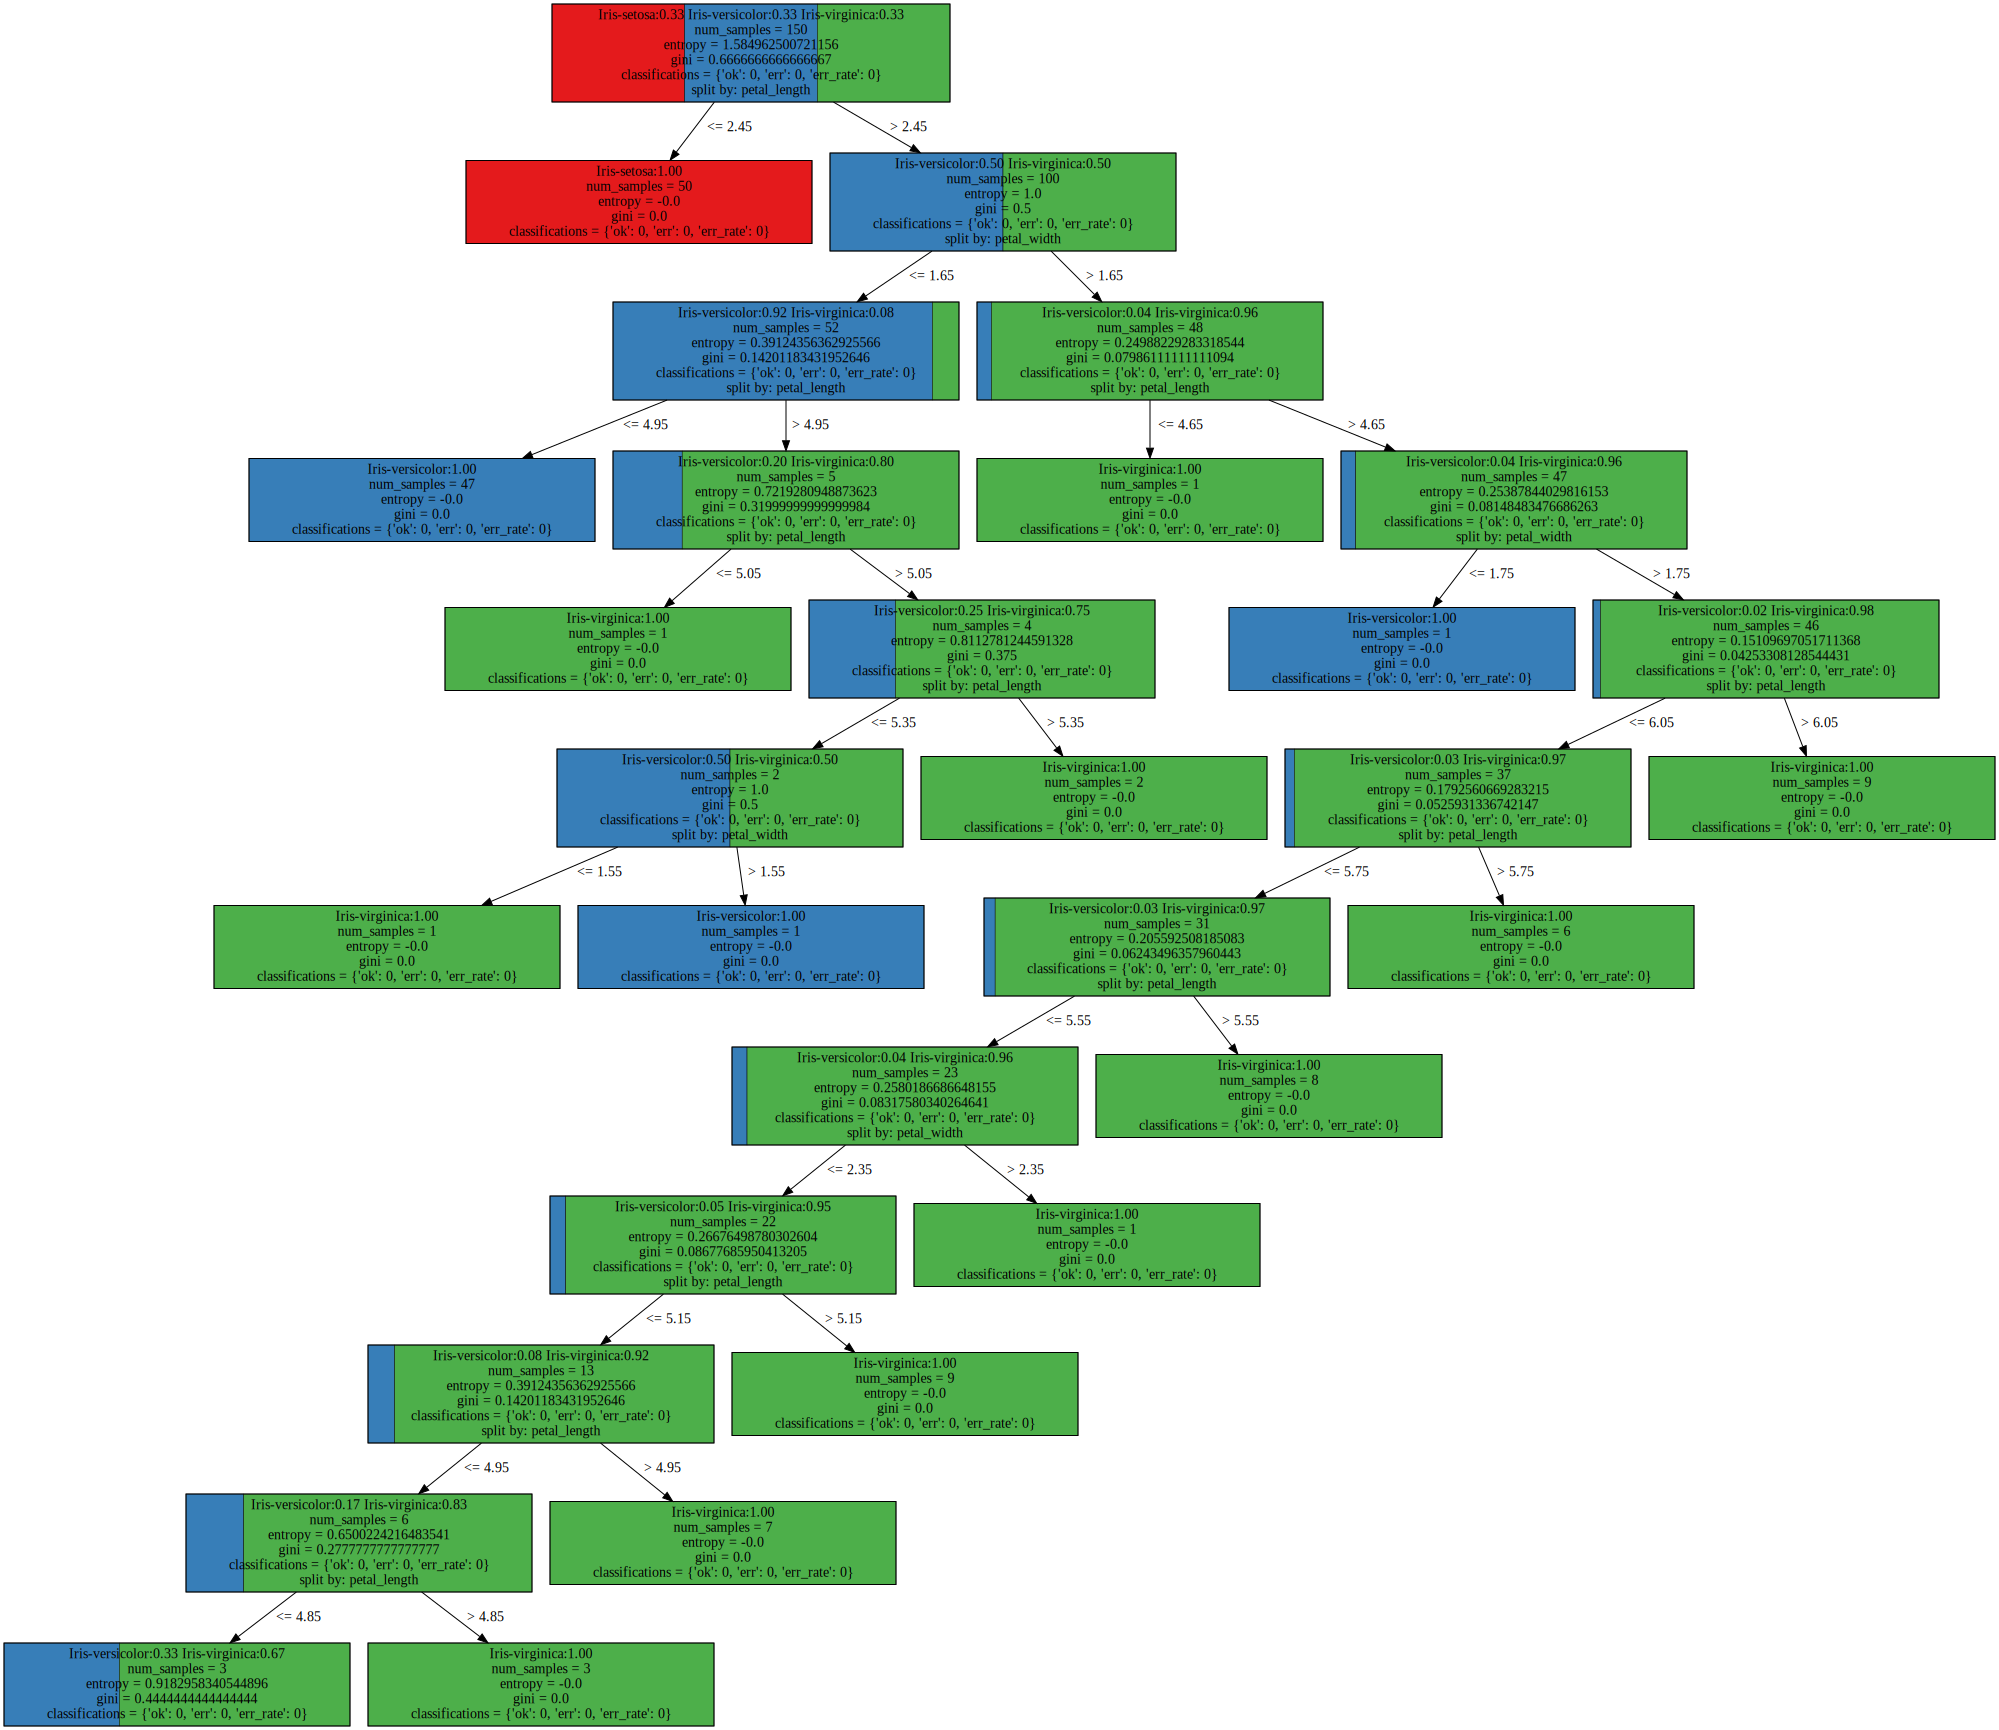

In [227]:
# TODO: apply the tree to Iris with petal_length and petal_width attributes
iris2d = iris_df[["petal_length", "petal_width", "target"]]

iris_tree = Tree(iris2d)
iris_tree.draw()

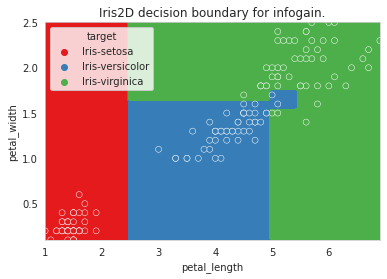

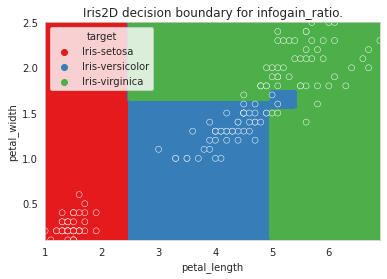

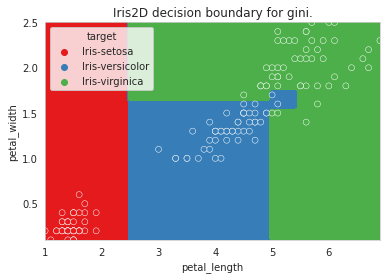

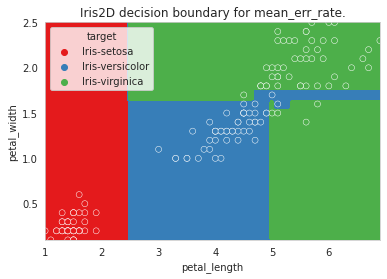

In [87]:
# TODO: to verify the tree building algorithm draw Iris2D decision boundary
# for different splitting criteria.
mesh_x, mesh_y = np.meshgrid(
    np.linspace(iris2d.petal_length.min(), iris2d.petal_length.max(), 100),
    np.linspace(iris2d.petal_width.min(), iris2d.petal_width.max(), 100),
)

mesh_data = np.hstack([mesh_x.reshape(-1, 1), mesh_y.reshape(-1, 1)])
mesh_data = pd.DataFrame(mesh_data, columns=iris2d.columns[:-1])

preds = np.empty((len(mesh_data),))

for criterion in ["infogain", "infogain_ratio", "gini", "mean_err_rate"]:
    iris2d_tree = Tree(iris2d, criterion=criterion)
    for i, (_, r) in enumerate(mesh_data.iterrows()):
        preds[i] = iris2d_tree.all_targets.index(iris2d_tree.classify(r))

    plt.figure()
    plt.title(f"Iris2D decision boundary for {criterion}.")
    plt.contourf(
        mesh_x, mesh_y, preds.reshape(mesh_x.shape), cmap="Set1", vmin=0, vmax=7
    )
    sns.scatterplot(
        x="petal_length", y="petal_width", hue="target", data=iris_df, palette="Set1",
    )

## Decision Tree Task 4: Handling missing data [2p]

Implement support for missing values. A possible strategy does the following:
each time (both during training and testing) we encounter a split for which the sample misses attribute's value, we put a weighted copy of the sample down each subtree, with the weight equal to the probability that the child subtree is selected (i.e. proportional to number of samples put into the subtree.).

## Decision Tree Task 5: Pruning [4p]

Tree pruning tries to remove splits that don't result in a decrease of the error rate.

There are two possible strategies:

### 1. Reduced Error Rate Pruning [2p]
Build a tree using all the data. Then split the training set into 10 cross-validation subsets. Then in a loop over the testing cross-validation subset:
- put the data from the remaining 9 subsets through the tree, remember distributions at each node (leaf and internal nodes)
- classify the samples in the testing subset, record the error rate for all nodes 
- remove leaf nodes that have a higher error rate than their parents.

### 2. Confidence-interval Pruning [2p]
Build the decision tree and record the class distribution in each node. For each node, estimate the upper confidence interval on the error rate. Remove nodes that have a higher upper bound on the error rate than their parents.
Remember the homework task on how Reddit sorts comments? The way to do it is to score by lower confidence intervals, approximation of which is calculated using the so called Wilson score https://en.wikipedia.org/wiki/Binomial_proportion_confidence_interval#Wilson_score_interval. Here you need to use the upper interval, but you can still use the Wilson score.


As you can see, the two strategies are quite similar: both estimate the error rate for all nodes in the tree and remove subtrees that do not improve it. The difference stems from the way in which the error rates are computed.

### Task: 

Split the voting dataset into a training and testing set using a 70%-30% ratio.

Train a decision tree and prune it using either method 1. or 2.

Compare the error rates on the test set of the original and pruned tree.

**Implementation hint**: you can store the information related to pruning in the `Tree.info` field. In this way, it will be printed by `Tree.draw` method.

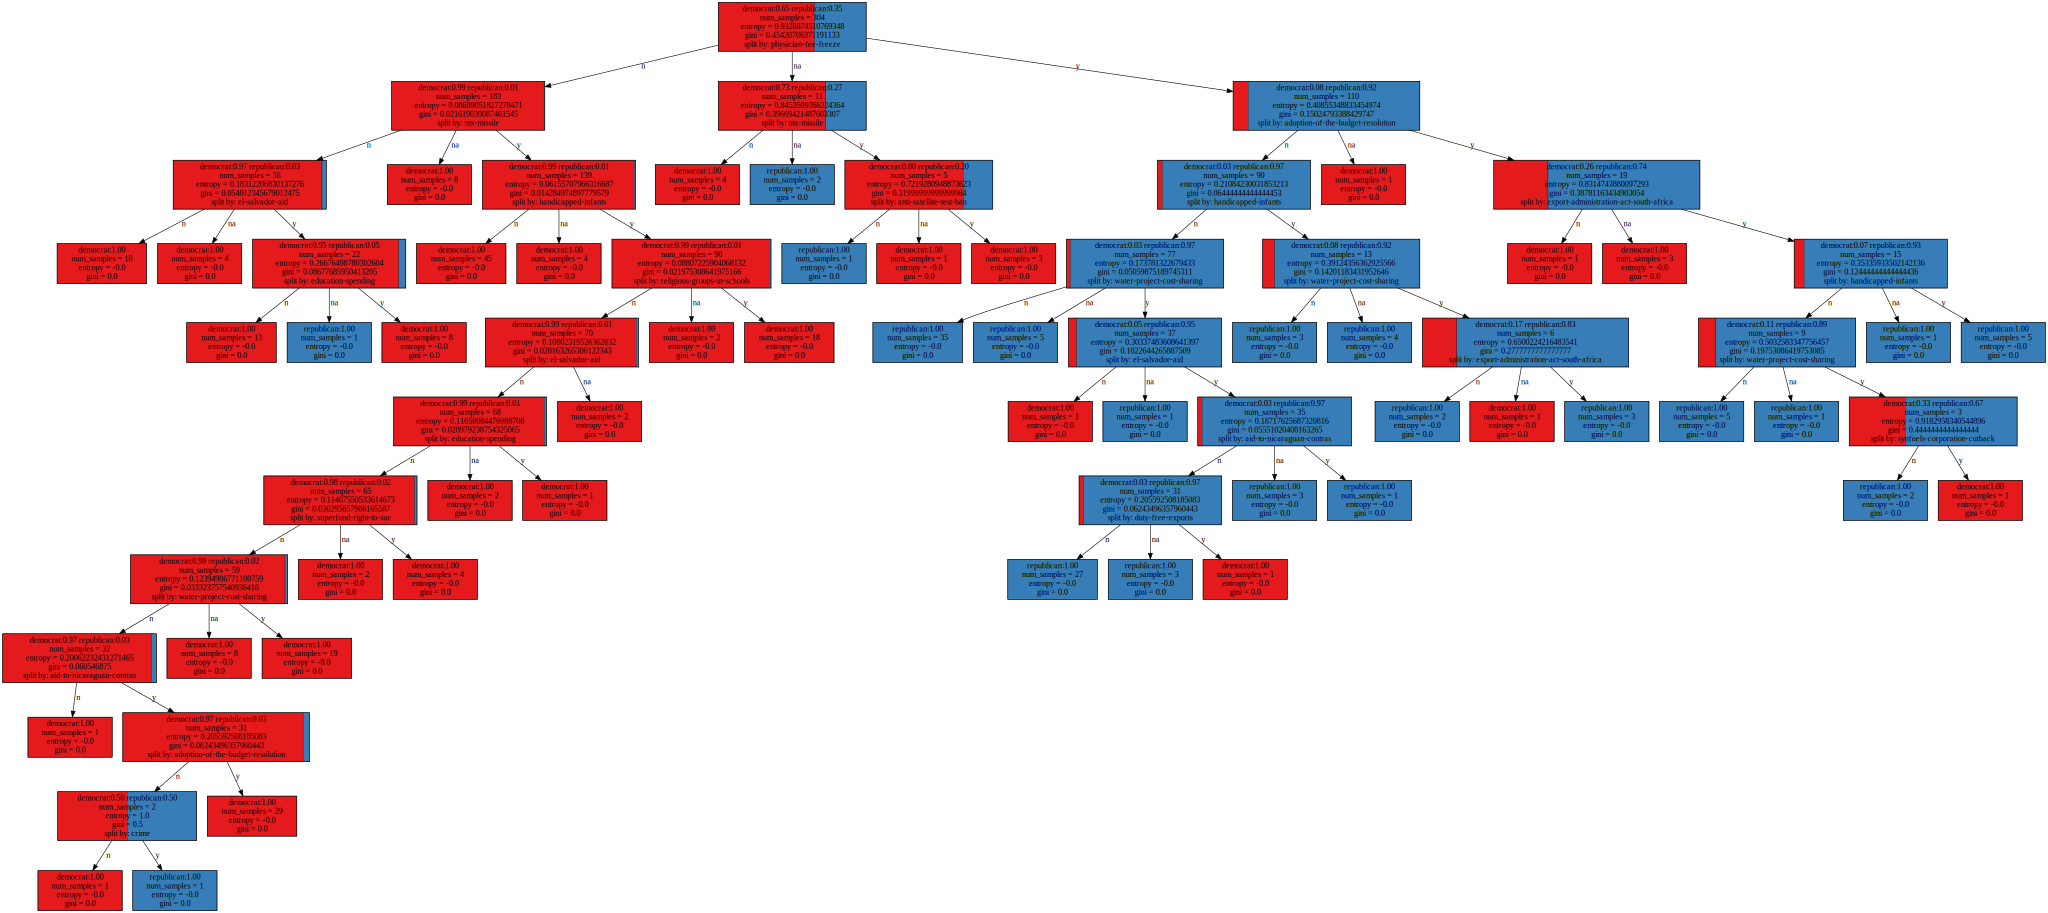

In [36]:
vote_train_df, vote_test_df = sklearn.model_selection.train_test_split(
    vote_df, test_size=0.3
)

vote_tree = Tree(vote_train_df)
vote_tree.draw()
# TODO: Build and draw the tree


In [37]:
def test(tree, df):
    wrong_classifications = 0

    for i, row in df.iterrows():
        if tree.classify(row) != row['target']:
            wrong_classifications += 1

    print(f"Err rate: {wrong_classifications / len(df)}")

test(vote_tree, vote_test_df)

Err rate: 0.061068702290076333


Err rate: 0.08396946564885496


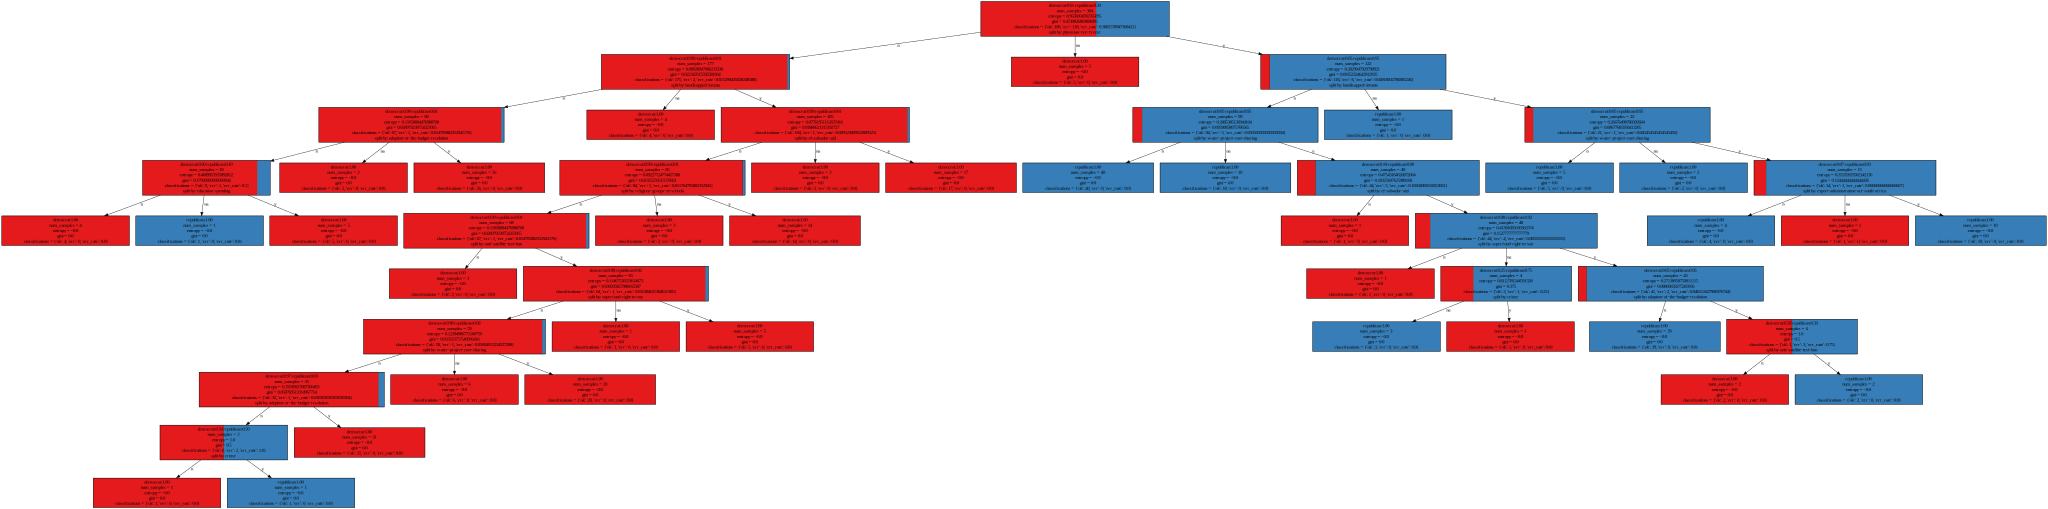

In [248]:
# TODO: implement a pruning method of your choice
splited = np.array_split(vote_train_df, 10)

vote_pruned_tree = Tree(vote_train_df)

for i in range(10):
    for j in range(10):
        if j != i:
            for _, row in splited[j].iterrows():
                vote_pruned_tree.log_distribution(row)

    for _, row in splited[i].iterrows():
        vote_pruned_tree.log_classification(row)

    # vote_pruned_tree.reset_pruning_counts()
    
vote_pruned_tree.prune_leaves()
# vote_pruned_tree.reset_classification_info()
wrong_classifications = 0

for i, row in vote_test_df.iterrows():
    if vote_pruned_tree.classify(row) != row['target']:
        wrong_classifications += 1

print(f"Err rate: {wrong_classifications / len(vote_test_df)}")


vote_pruned_tree.draw()

Err rate: 0.16793893129770993


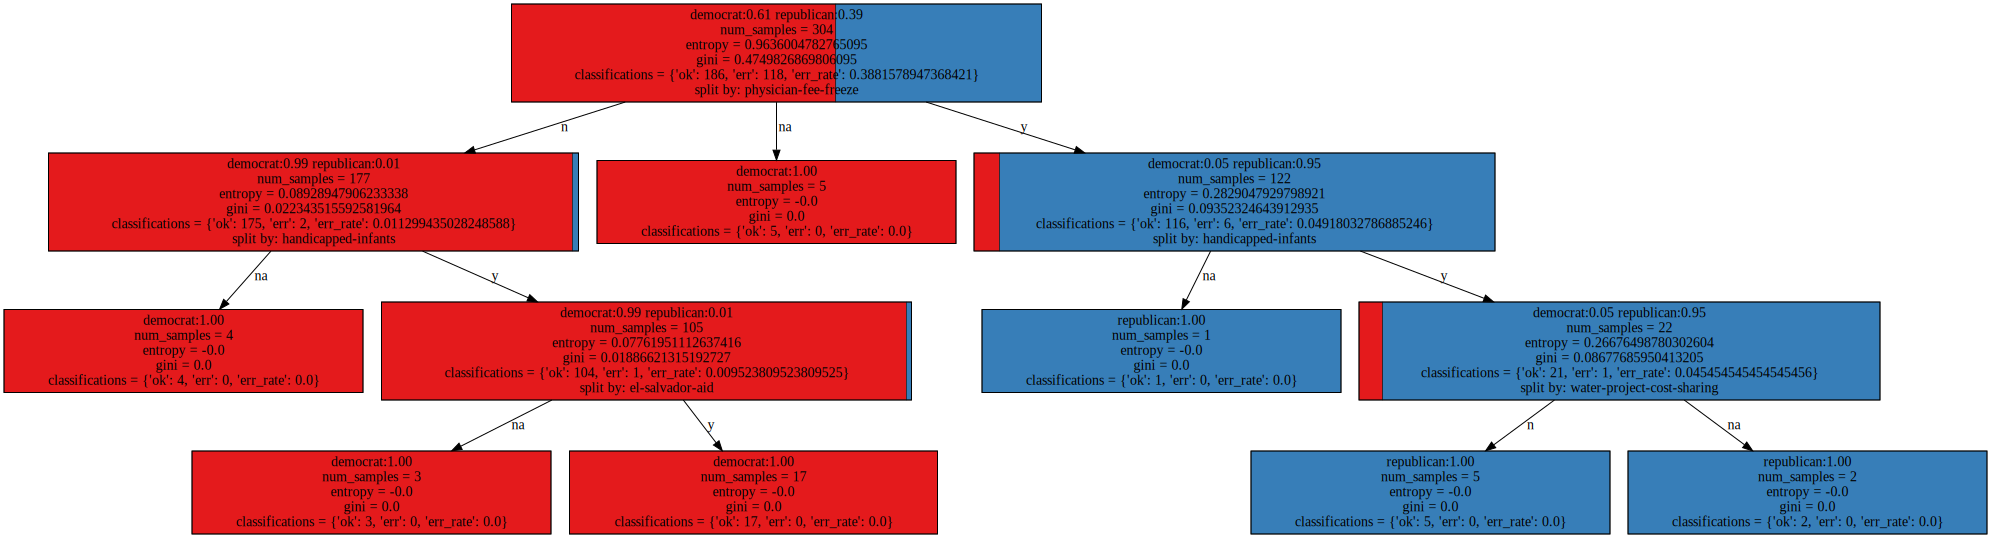

In [249]:
vote_pruned_tree.prune_nodes()

for i, row in vote_test_df.iterrows():
    if vote_pruned_tree.classify(row) != row['target']:
        wrong_classifications += 1

print(f"Err rate: {wrong_classifications / len(vote_test_df)}")


vote_pruned_tree.draw()

# Problem 3: Random Forest [3p]

We will use the German credit dataset. Please split it into a training and testing set using a 70%-30% ratio.

Next, train and test a regular decision tree on it.

Then:
1. Implement randomized tree bulding, by restricting the set of attrbutes considered for data splitting in the tree building code below (the `nattrs` argument). Alternatively, you can use trees from `sklearn` (see below).
2. Build a forest of at least 20 Random Trees, each selecting splits out of 1-3 attributes on the German Credit data. After adding each random tree:
    - Compute the tree's test error rate and its OOB error rate
    - Record the accurracy of the RF after adding the tree to it. 
    
    At the end ot training record the forest's OOB error rate.

What is the mean accurracy of individual trees in the forest? What is the final forest accurracy? 

Define the agreement between two trees to be the fraction of test samples on which the answer of the two trees is identical. What is the mean aggreement of trees in the forest? How does it change with the number of attributes considered for each split? What is the impact of training each tree in the forest on a bootstrap sample, rather than on the full train set?

**Note:** This assignment assumes that you use either your own implementation of the decision tree from Problem 3, or the implementation of [trees from sklearn](https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html). Since sklearn's trees don't support categorical attributes, use the numerical variant of the German Credit dataset (cf. last year's AdaBoost demo at https://github.com/janchorowski/ml_uwr/blob/fall2019/lectures/05_adabost_demo.ipynb), or try to encode the categorical variables using the [1-Hot Encoder](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.OneHotEncoder.html).

Err rate: 0.35333333333333333


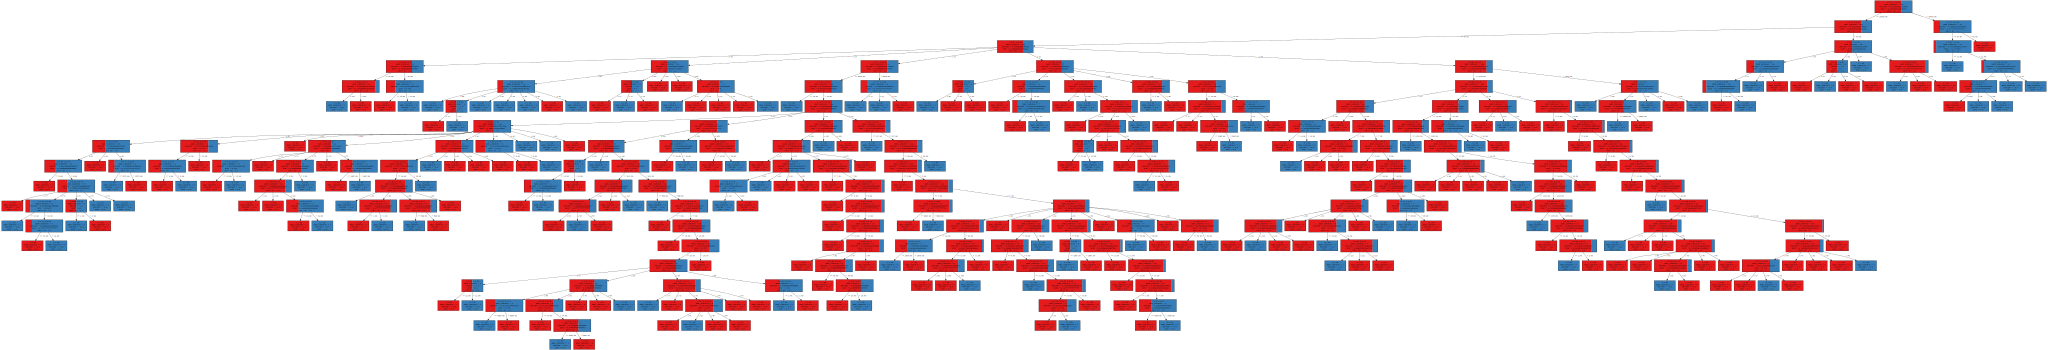

In [71]:
german_df
german_train_df, german_test_df = sklearn.model_selection.train_test_split(
    german_df, test_size=0.3
)

german_tree = Tree(german_train_df)
test(german_tree, german_test_df)
german_tree.draw()
# TODO: Build and draw the tree

In [96]:
def most_frequent(arr):
    return max(set(arr), key=arr.count)


class RandomForest:
    def __init__(self, train_df, test_df) -> None:
        self.train_df = train_df
        self.test_df = test_df

        self.trees = []
        self.bootstraped_indexes = []
        self.test_trees_err_rates = []
        self.oob_trees_err_rates = []
        self.partial_forests_err_rates = []

    def add_tree(self):
        n = len(self.train_df)
        train_data_indexes = np.random.randint(0, n, n)
        self.bootstraped_indexes.append(train_data_indexes)

        tree = Tree(self.train_df.iloc[train_data_indexes], nattrs=np.random.randint(1,4))
        self.trees.append(tree)

        oob_data = self.train_df.iloc[list(set(range(len(self.test_df))) - set(train_data_indexes))]

        oob_check_classify = [tree.classify(sample) != sample['target'] for _,sample in oob_data.iterrows()]

        self.oob_trees_err_rates.append(np.array(oob_check_classify).mean())

        test_check_classify = [tree.classify(sample) != sample['target'] for _,sample in self.test_df.iterrows()]

        self.test_trees_err_rates.append(np.array(test_check_classify).mean())

        self.partial_forests_err_rates.append(self.forest_err_rate())

    def forest_err_rate(self):
        return 1-np.array([self.sample_classify(sample)[1] for _, sample in self.test_df.iterrows()]).mean()

    def sample_classify(self, sample, trees_set = []):
        if trees_set == []:
            trees_set = self.trees

        trees_results = [tree.classify(sample) for tree in trees_set]

        result = most_frequent(trees_results)
        is_correct = result == sample['target']

        return result, is_correct

    def oob_err_rate(self):
        trees = np.array(self.trees)

        samples_checks = []

        for i in range(len(german_train_df)):
            trees_indexes = [j for j in range(len(self.bootstraped_indexes)) if i not in self.bootstraped_indexes[j]]

            samples_checks.append(self.sample_classify(german_train_df.iloc[i], trees[trees_indexes])[1])


        return 1-np.array(samples_checks).mean()

        # test_classification = [tree.classify(sample) for sample in self.test_df.iterrows()]

forest = RandomForest(german_train_df, german_test_df)

for _ in range(20):
    forest.add_tree()



In [97]:
print(f"Trees err_rate for test data:\n {forest.oob_trees_err_rates}")
print(f"Trees OOB err_rate:\n {forest.oob_trees_err_rates}")
print(f"Forest err_rate after adding each tree:\n {forest.partial_forests_err_rates}")
print(f"Forest OOB err_rate: {forest.oob_err_rate()}")

Trees err_rate for test data:
 [0.4017094017094017, 0.31683168316831684, 0.3963963963963964, 0.3564356435643564, 0.2882882882882883, 0.3564356435643564, 0.3629032258064516, 0.32727272727272727, 0.4462809917355372, 0.36607142857142855, 0.3114754098360656, 0.34782608695652173, 0.3235294117647059, 0.3769230769230769, 0.3669724770642202, 0.3644859813084112, 0.4, 0.36792452830188677, 0.3235294117647059, 0.3157894736842105]
Trees OOB err_rate:
 [0.4017094017094017, 0.31683168316831684, 0.3963963963963964, 0.3564356435643564, 0.2882882882882883, 0.3564356435643564, 0.3629032258064516, 0.32727272727272727, 0.4462809917355372, 0.36607142857142855, 0.3114754098360656, 0.34782608695652173, 0.3235294117647059, 0.3769230769230769, 0.3669724770642202, 0.3644859813084112, 0.4, 0.36792452830188677, 0.3235294117647059, 0.3157894736842105]
Forest err_rate after adding each tree:
 [0.4066666666666666, 0.32333333333333336, 0.32999999999999996, 0.31666666666666665, 0.31333333333333335, 0.28, 0.300000000000

/tmp/ipykernel_77655/478275626.py:40: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if trees_set == []:
/tmp/ipykernel_77655/478275626.py:40: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if trees_set == []:


Forest OOB err_rate: 0.28428571428571425


# Problem 4: Implement Variable importance using Random Forests [2p]

Implement the two measures of variable importance in a Random Forest:
1. Total purity increase for all splits using this variable [1p]
2. Forest performance decrease on replacing an attribute with random data. [1p]

Then analyze the variable importance on some datasets (e.g. mushroom and German credit).

# Problem 5: More analysis using Random Forests [2p]

Given a Random Forest you can inspect for two data points how often they ended up in the same leaf node.
If some two datapoints end up always in the same node, then we can think of them as very similar, when looking through the point of view of Random Forest. Conversely, if they never end up in the same leaf, then Random Forest thinks they are not very similar.
If you will average the number of times a pair ends up in the same leaf, then you can create the so called *proximity* matrix. Now this matrix can be used in many applications.

One of them is data clustering, another is data visualization.

**Note** Clustering based on Random Forest can be also used in a totally unsupervised manner, where we do not use the target column, and instead random forest tries to predict some features based on other features. However below just for the demonstration purposes we use the outcome of a random forest which was trained in a supervised way.


## Implement the proximity matrix [2p]

In [91]:
from sklearn.datasets import load_breast_cancer
bc_data = load_breast_cancer(as_frame=True)
X, y = bc_data['data'], bc_data['target']
y.name = 'benign'

In [92]:
X

,mean radius,mean texture,mean perimeter,mean area,mean smoothness,mean compactness,mean concavity,mean concave points,mean symmetry,mean fractal dimension,...,worst radius,worst texture,worst perimeter,worst area,worst smoothness,worst compactness,worst concavity,worst concave points,worst symmetry,worst fractal dimension
0,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.30010,0.14710,0.2419,0.07871,...,25.380,17.33,184.60,2019.0,0.16220,0.66560,0.7119,0.2654,0.4601,0.11890
1,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.08690,0.07017,0.1812,0.05667,...,24.990,23.41,158.80,1956.0,0.12380,0.18660,0.2416,0.1860,0.2750,0.08902
2,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.19740,0.12790,0.2069,0.05999,...,23.570,25.53,152.50,1709.0,0.14440,0.42450,0.4504,0.2430,0.3613,0.08758
3,11.42,20.38,77.58,386.1,0.14250,0.28390,0.24140,0.10520,0.2597,0.09744,...,14.910,26.50,98.87,567.7,0.20980,0.86630,0.6869,0.2575,0.6638,0.17300
4,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.19800,0.10430,0.1809,0.05883,...,22.540,16.67,152.20,1575.0,0.13740,0.20500,0.4000,0.1625,0.2364,0.07678
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
564,21.56,22.39,142.00,1479.0,0.11100,0.11590,0.24390,0.13890,0.1726,0.05623,...,25.450,26.40,166.10,2027.0,0.14100,0.21130,0.4107,0.2216,0.2060,0.07115
565,20.13,28.25,131.20,1261.0,0.09780,0.10340,0.14400,0.09791,0.1752,0.05533,...,23.690,38.25,155.00,1731.0,0.11660,0.19220,0.3215,0.1628,0.2572,0.06637
566,16.60,28.08,108.30,858.1,0.08455,0.10230,0.09251,0.05302,0.1590,0.05648,...,18.980,34.12,126.70,1124.0,0.11390,0.30940,0.3403,0.1418,0.2218,0.07820
567,20.60,29.33,140.10,1265.0,0.11780,0.27700,0.35140,0.15200,0.2397,0.07016,...,25.740,39.42,184.60,1821.0,0.16500,0.86810,0.9387,0.2650,0.4087,0.12400


In [93]:
y

0      0
1      0
2      0
3      0
4      0
      ..
564    0
565    0
566    0
567    0
568    1
Name: benign, Length: 569, dtype: int64

In [94]:
#TODO here implement the proximity matrix

proximity_matrix.shape, proximity_matrix

NameError: name 'proximity_matrix' is not defined

<AxesSubplot:>

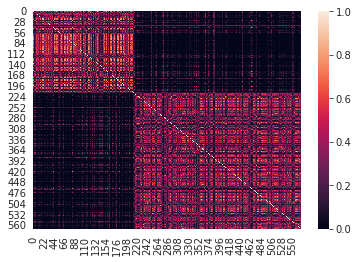

In [ ]:
import seaborn as sns

sns.heatmap(proximity_matrix[np.argsort(y), :][:,np.argsort(y)])

## MDS scaling and visualization

https://scikit-learn.org/stable/modules/manifold.html#multidimensional-scaling

In [ ]:
# in proximity matrix 1 means points are identical
# mds needs something which resembles metrix, so it needs matrix where identical points have value 0
dissimilarity_matrix = 1.0 - proximity_matrix
dissimilarity_matrix

array([[0.   , 0.6  , 0.182, ..., 0.862, 0.162, 1.   ],
       [0.6  , 0.   , 0.64 , ..., 0.668, 0.694, 0.986],
       [0.182, 0.64 , 0.   , ..., 0.794, 0.132, 1.   ],
       ...,
       [0.862, 0.668, 0.794, ..., 0.   , 0.812, 0.974],
       [0.162, 0.694, 0.132, ..., 0.812, 0.   , 1.   ],
       [1.   , 0.986, 1.   , ..., 0.974, 1.   , 0.   ]])

In [ ]:
from sklearn.manifold import MDS
embedding = MDS(n_components=2, dissimilarity='precomputed')
X_transformed = embedding.fit_transform( dissimilarity_matrix)

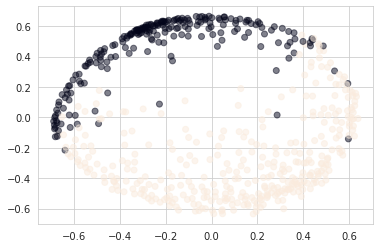

In [ ]:
import matplotlib.pyplot as plt

# Fixing random state for reproducibility
np.random.seed(1)

plt.scatter(X_transformed[:,0], X_transformed[:,1], c=y, alpha=0.5)
plt.show()

## Clustering 

https://scikit-learn.org/stable/modules/clustering.html#hierarchical-clustering

In [ ]:
import numpy as np

from matplotlib import pyplot as plt
from scipy.cluster.hierarchy import dendrogram
from sklearn.datasets import load_iris
from sklearn.cluster import AgglomerativeClustering


# setting distance_threshold=0 ensures we compute the full tree.
cluster = AgglomerativeClustering(affinity='precomputed', linkage='complete')
cluster.fit(dissimilarity_matrix)

(cluster.labels_ == y).mean()

0.8822495606326889

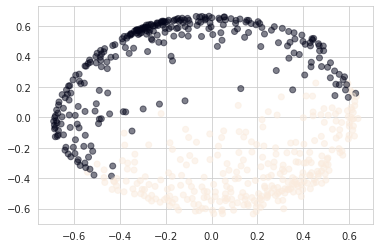

In [ ]:
import matplotlib.pyplot as plt

# Fixing random state for reproducibility
np.random.seed(1)

plt.scatter(X_transformed[:,0], X_transformed[:,1], c=cluster.labels_, alpha=0.5)
plt.show()